In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
import ipywidgets as widgets
from IPython.display import display
from enhancement_analysis import *
from fit_functions import *
from low_level import readCSVrows,writeCSVrows,calcEnhancement,readCSVcolumns
%matplotlib inline


In [2]:
results=readCSVcolumns('Processed_20190411/data_legend_pulsed_enhancement.csv',skip_header=1)
header = results[1]
print(header)
[iv,starts,stops]= results[0]

Done! Array read from Processed_20190411/data_legend_pulsed_enhancement.csv
[['Start Relative to Trigger (ms)', 'Start', 'Stop']]


A Jupyter Widget

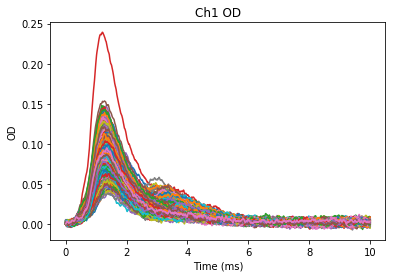

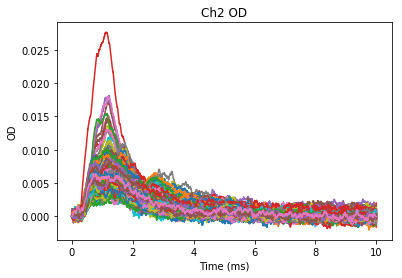

In [4]:
folder = '20190411'
skips = []
ABAB = True

start_arr = starts.astype(int)
stop_arr = stops.astype(int)
iv_arr = iv

enhancement = []

b_ODs = []
ub_ODs = []
b_int = []
ub_int = []

progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
display(progress)

for _start,_stop,i in zip(start_arr,stop_arr,range(0,len(start_arr)*3,3)):
    
    ODs_1 = calculateSeriesOD(folder,_start,_stop,skips,ABAB=ABAB)
    int_1 = processData(ODs_1,[0,10])
    progress.value = float(i/(len(start_arr)*3))
    i+=1
    ODs_2 = calculateSeriesOD(folder,_start+1,_stop,skips,ABAB=ABAB)
    int_2 = processData(ODs_2,[0,10])
    progress.value = float(i/(len(start_arr)*3))
    i+=1
    b,ub,firstBlocked = identifyBUB(int_1,int_2,ch=2,equal=True,returnBool=True)
    b_int.append(b)
    ub_int.append(ub)
    if firstBlocked:
        b_ODs.append(ODs_1)
        ub_ODs.append(ODs_2)
    else:
        b_ODs.append(ODs_2)
        ub_ODs.append(ODs_1)
    progress.value = float(i/(len(start_arr)*3))
    i+=1
progress.value=1
#p=YbOH integrated, Yb integrated, timestamp

In [5]:
en_ch1 = []
en_ch2 = []
for _b,_ub in zip(b_int,ub_int):
    _en1 = calcEnhancement(_b[0],_ub[0])
    en_ch1.append(_en1)
    _en2 = calcEnhancement(_b[1],_ub[1])
    en_ch2.append(_en2)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


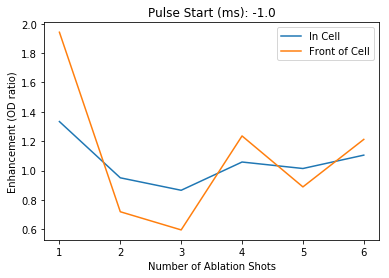

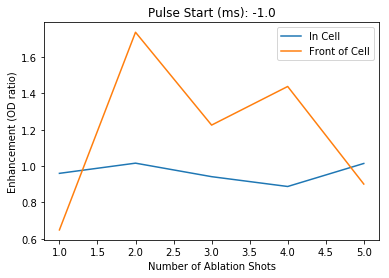

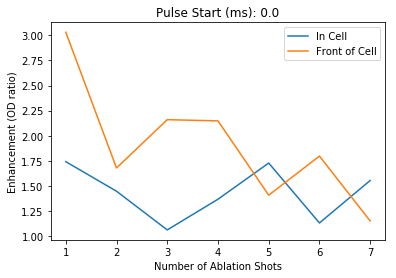

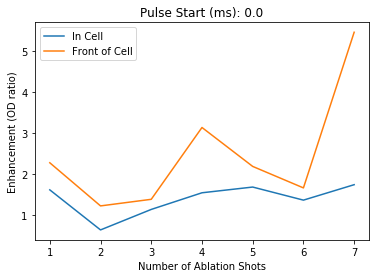

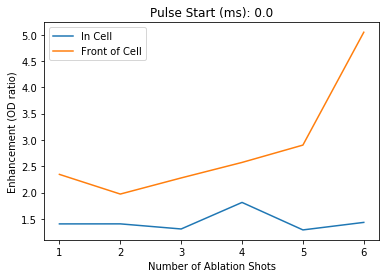

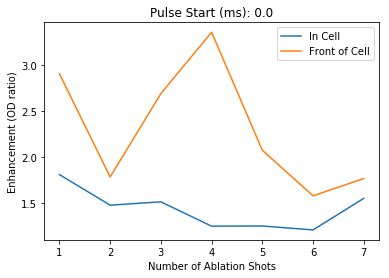

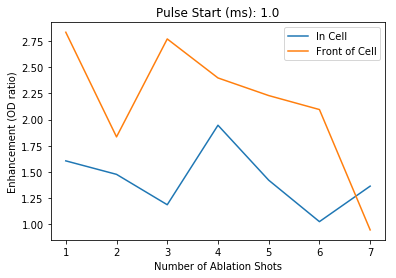

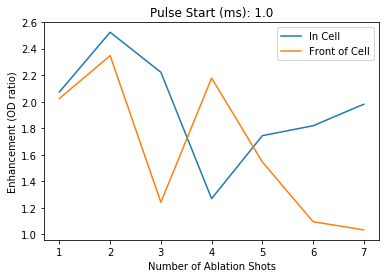

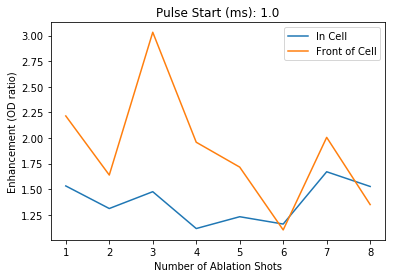

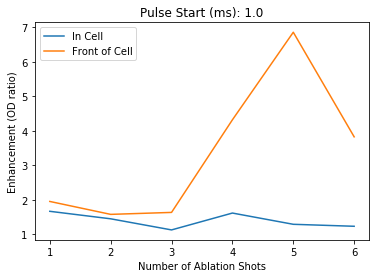

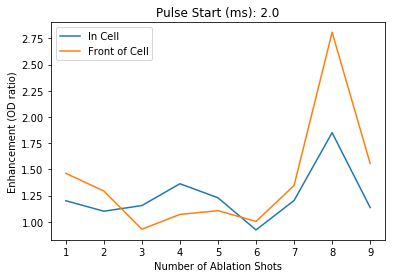

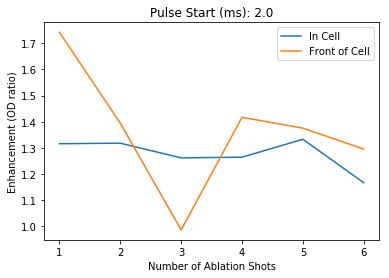

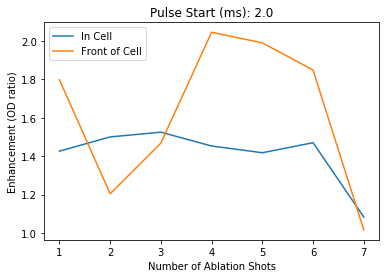

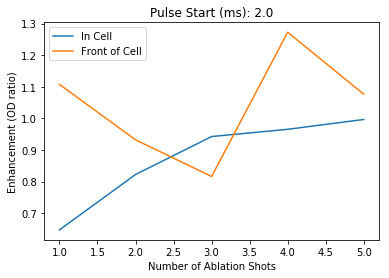

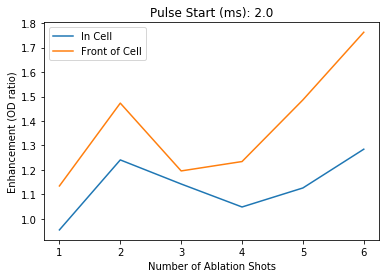

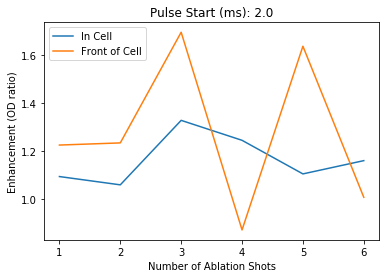

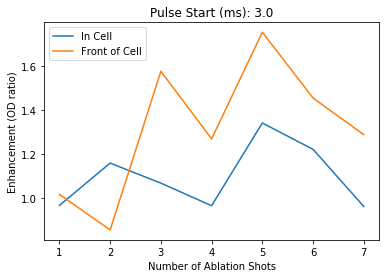

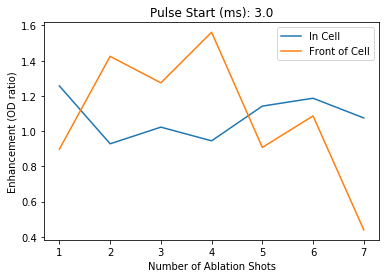

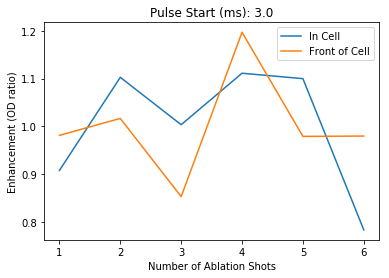

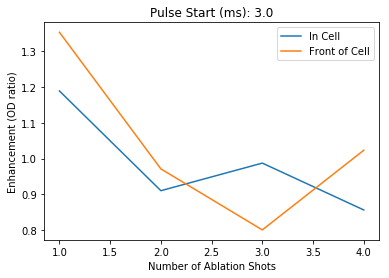

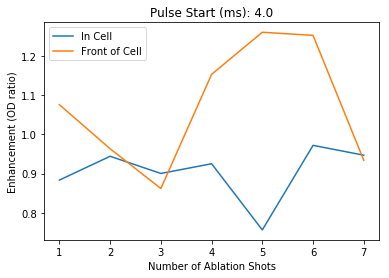

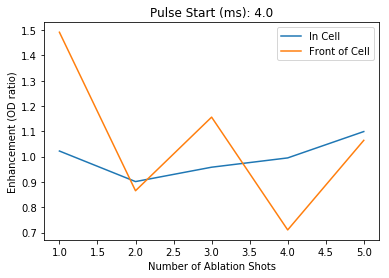

In [6]:
cell = []
err_cell = []
front = []
err_front = []
for _en1,_en2,_iv in zip(en_ch1,en_ch2,iv):
    plt.figure()
    x = np.arange(1,len(_en1)+1)
    plt.title('Pulse Start (ms): {}'.format(_iv))
    plt.ylabel('Enhancement (OD ratio)')
    plt.xlabel('Number of Ablation Shots')
    plt.plot(x,_en1,label='In Cell')
    plt.plot(x,_en2,label='Front of Cell')
    plt.legend(loc='best')
    cell.append(np.array(_en1).mean())
    err_cell.append(np.array(_en1).std())
    front.append(np.array(_en2).mean())
    err_front.append(np.array(_en2).std())

In [7]:
en_cell_sort = np.array(sortData(iv,cell))
err_cell_sort = np.array(sortData(iv,err_cell))
en_front_sort = np.array(sortData(iv,front))
err_front_sort = np.array(sortData(iv,err_front))
iv_sort = np.array(sorted(iv))

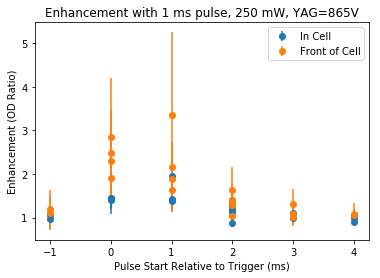

In [8]:
plt.figure()
plt.title('Enhancement with 1 ms pulse, 250 mW, YAG=865V')
plt.xlabel('Pulse Start Relative to Trigger (ms)')
plt.ylabel('Enhancement (OD Ratio)')
plt.errorbar(iv_sort,en_cell_sort,yerr=err_cell_sort,marker='o',linestyle='None',label='In Cell')
plt.errorbar(iv_sort,en_front_sort,yerr=err_front_sort,marker='o',linestyle='None',label='Front of Cell')
plt.legend(loc='best')

In [13]:
lbls = ['Pulse Start Relative to Trigger (ms)','In Cell Enhancement','In Cell StDev','Front of Cell Enhancement','Front of Cell StDev']
data = np.array([np.array(iv_sort),np.array(en_cell_sort),np.array(err_cell_sort),np.array(en_front_sort),np.array(err_front_sort)])
save_all = []
save_all.append(lbls)
for _data in data.T:
    save_all.append(_data)
writeCSVrows(save_all,'Processed_20190411/Pulsed_1ms_Enhancement_vs_Start_250mW.csv')

Done! Array written to Processed_20190411/Pulsed_1ms_Enhancement_vs_Start_250mW.csv


In [9]:
t0 = b_ODs[0][-1][0][1]
dt = b_ODs[0][-1][0][0]

for _b in b_ODs:
    if _b[-1][0][1] != t0:
        print(_b[-1][0][1])
    if _b[-1][0][0] != dt:
        print(_b[-1][0][0])

In [10]:
time_ms = timeArray(b_ODs[0][-1][0])

In [11]:
ch1_diff = []
ch2_diff = []
for _b,_ub in zip(b_ODs,ub_ODs):
    _b1 = _b[0]
    _b2 = _b[1]
    _ub1 = _ub[0]
    _ub2 = _ub[1]
    _d1 = []
    _d2 = []
    for b1,ub1,b2,ub2 in zip(_b1,_ub1,_b2,_ub2):
        _diff1 = (ub1 - b1)
        _diff2 = (ub2 - b2)
#         thresh = 0.0001
#         n1 = np.copy(b1)
#         n2 = np.copy(b2)
#         n1[n1<thresh] = thresh
#         n2[n2<thresh] = thresh
        _d1.append(_diff1)
        _d2.append(_diff2)
    ch1_diff.append(_d1)
    ch2_diff.append(_d2)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


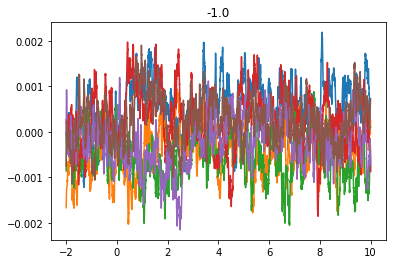

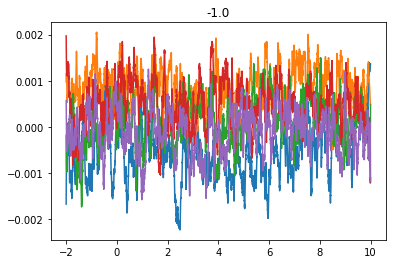

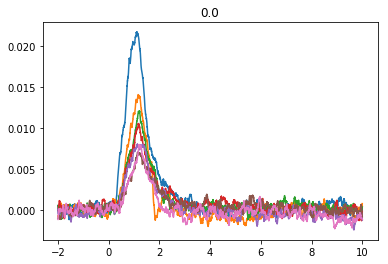

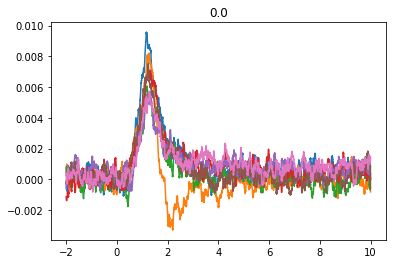

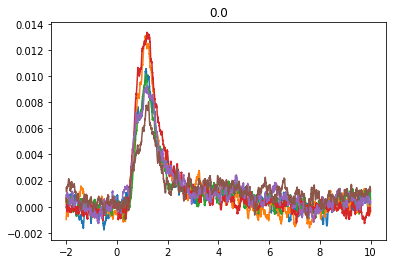

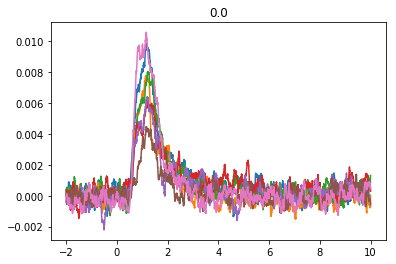

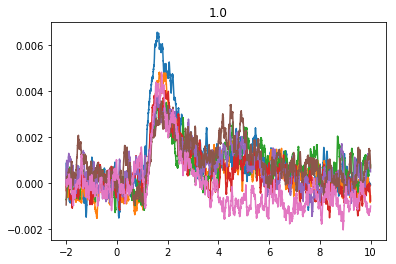

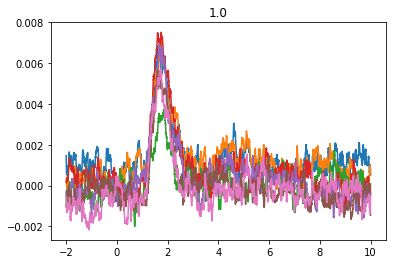

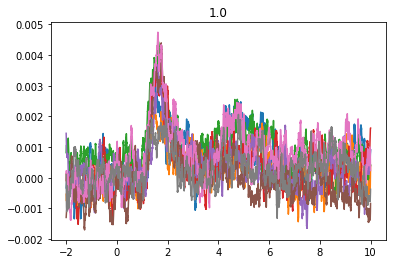

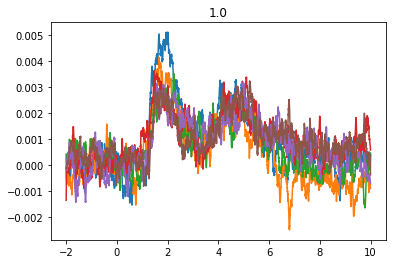

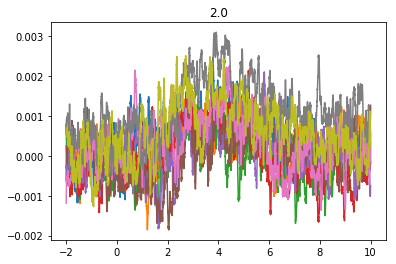

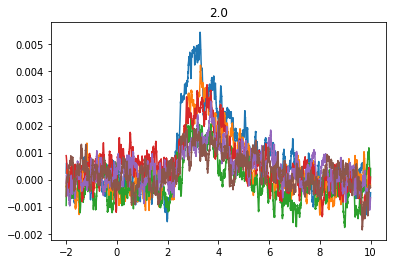

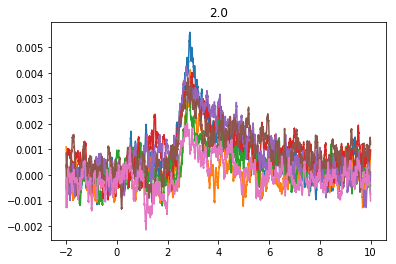

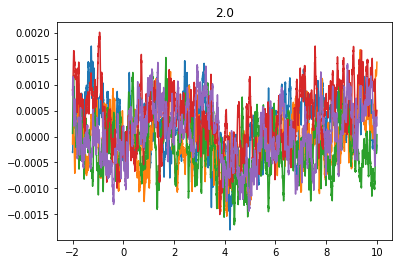

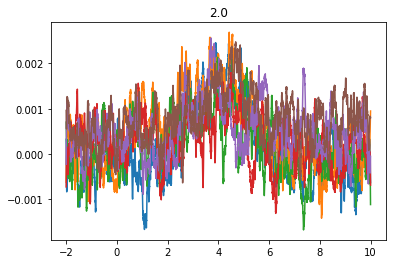

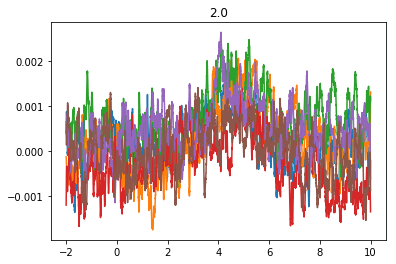

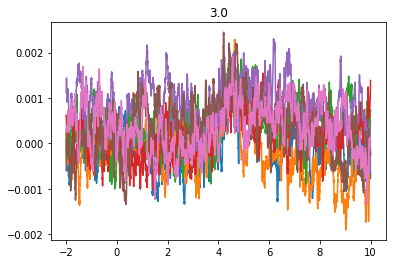

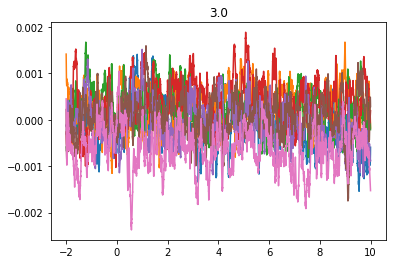

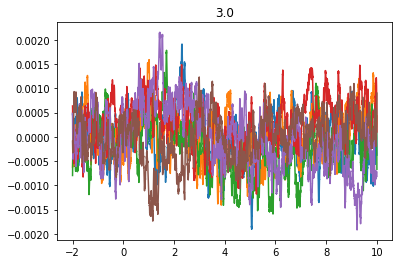

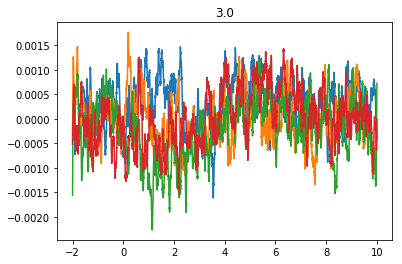

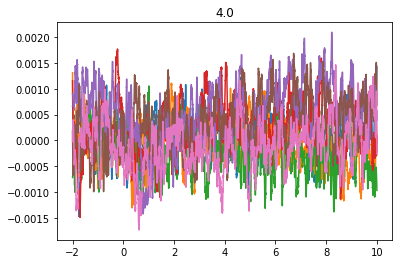

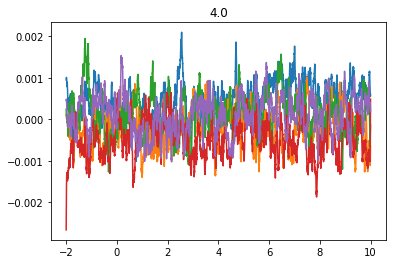

In [12]:
for _iv,iv_trace in zip(iv,ch2_diff):
    plt.figure()
    plt.title(_iv)
    for trace in iv_trace:
        plt.plot(time_ms,trace)

Text(0, 0.5, 'OD Difference')

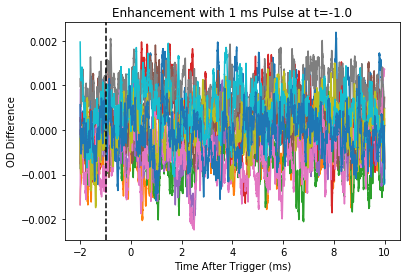

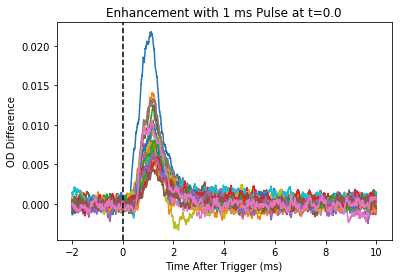

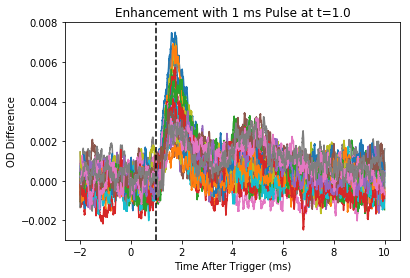

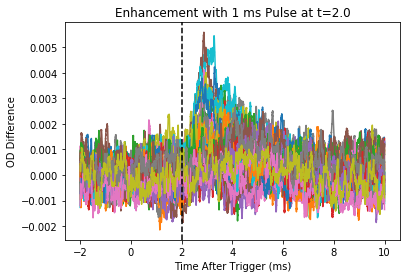

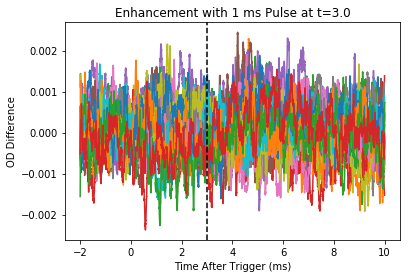

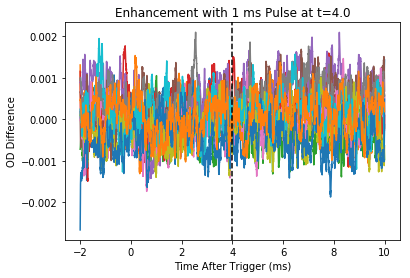

In [13]:
current = iv[0]
plt.figure()
for _iv,_ch1,_ch2 in zip(iv,ch1_diff,ch2_diff):
    if _iv == current:
        for trace in _ch2:
            plt.plot(time_ms,trace)
    elif _iv != current:
        plt.axvline(x=current,color='black',linestyle='--')
        plt.title('Enhancement with 1 ms Pulse at t={}'.format(current))
        plt.xlabel('Time After Trigger (ms)')
        plt.ylabel('OD Difference')
        plt.figure()
        current = _iv
        for trace in _ch2:
            plt.plot(time_ms,trace)
plt.axvline(x=current,color='black',linestyle='--')
plt.title('Enhancement with 1 ms Pulse at t={}'.format(current))
plt.xlabel('Time After Trigger (ms)')
plt.ylabel('OD Difference')

In [14]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def computeDelay(time_ms,en_time,trace,pulse_t):
    idx_enhance = find_nearest(time_ms,en_time)
    truncated = trace[idx_enhance:]
    idx_molecules = np.argmax(truncated)+idx_enhance
    deltat = time_ms[idx_molecules] - (en_time+pulse_t/2)
    deltat = np.round(deltat,decimals=4)
    return deltat

In [16]:
current = iv[0]
exit = []
exit_std = []
iv_single = [current]
_dummy = []
for _ch2,_iv in zip(ch2_diff,iv):
    if _iv == current:
        for _trace in _ch2:
            _dummy.append(computeDelay(time_ms,_iv,_trace,1))
    elif _iv != current:
        current = _iv
        iv_single.append(current)
        exit.append(np.array(_dummy).mean())
        exit_std.append(np.array(_dummy).std())
        _dummy = []
        for _trace in _ch2:
            _dummy.append(computeDelay(time_ms,_iv,_trace,1))
exit.append(np.array(_dummy).mean())
exit_std.append(np.array(_dummy).std())
for i in range(len(exit_std)):
    exit_std[i]=np.sqrt(exit_std[i]**2+0.5**2)

Text(0, 0.5, 'Time delay until extraction max (ms)')

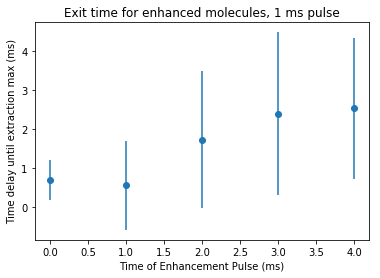

In [18]:
plt.errorbar(iv_single[1:],exit[1:],yerr=exit_std[1:],marker='o',linestyle='None')
plt.title('Exit time for enhanced molecules, 1 ms pulse')
plt.xlabel('Time of Enhancement Pulse (ms)')
plt.ylabel('Time delay until extraction max (ms)')

In [14]:
results=readCSVcolumns('Processed_20190411/data_legend_enhancement_duration.csv',skip_header=1)
header = results[1]
print(header)
[iv,starts,stops]= results[0]

Done! Array read from Processed_20190411/data_legend_enhancement_duration.csv
[['Duration (ms)', 'Start', 'Stop']]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

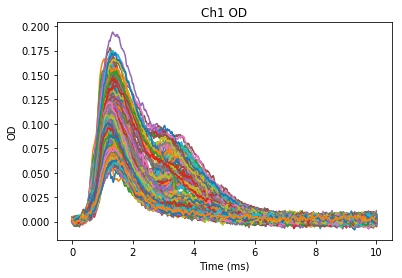

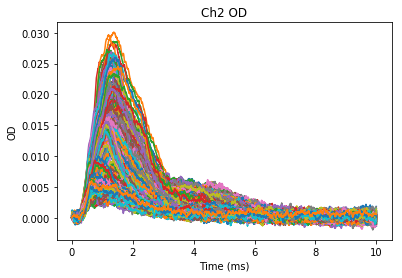

In [15]:
folder = '20190411'
skips = []
ABAB = True

start_arr = starts.astype(int)
stop_arr = stops.astype(int)
iv_arr = iv

enhancement = []

b_ODs = []
ub_ODs = []

progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
display(progress)

for _start,_stop,i in zip(start_arr,stop_arr,range(0,len(start_arr)*3,3)):
    
    ODs_1 = calculateSeriesOD(folder,_start,_stop,skips,ABAB=ABAB)
    p_1 = processData(ODs_1,[0,10])
    progress.value = float(i/(len(start_arr)*3))
    i+=1
    ODs_2 = calculateSeriesOD(folder,_start+1,_stop,skips,ABAB=ABAB)
    p_2 = processData(ODs_2,[0,10])
    progress.value = float(i/(len(start_arr)*3))
    i+=1
    b,ub = identifyBUB(p_1,p_2,equal=True)
    b_ODs.append(b)
    ub_ODs.append(ub)
    progress.value = float(i/(len(start_arr)*3))
    i+=1
progress.value=1
#p=YbOH integrated, Yb integrated, timestamp

In [16]:
en_ch1 = []
en_ch2 = []
for _b,_ub in zip(b_ODs,ub_ODs):
    _en1 = calcEnhancement(_b[0],_ub[0])
    en_ch1.append(_en1)
    _en2 = calcEnhancement(_b[1],_ub[1])
    en_ch2.append(_en2)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


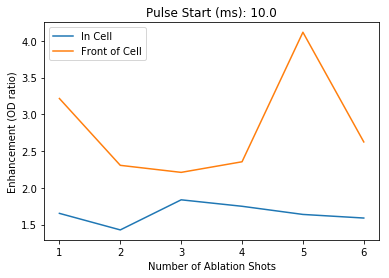

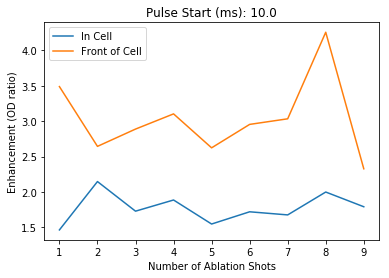

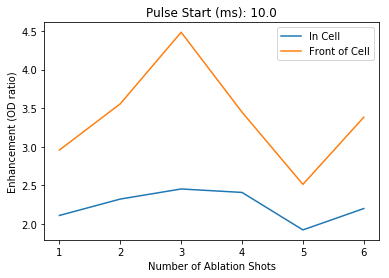

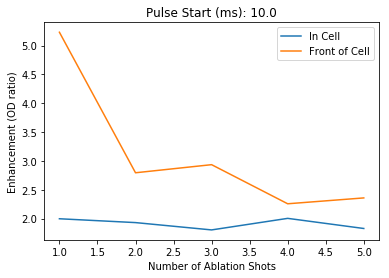

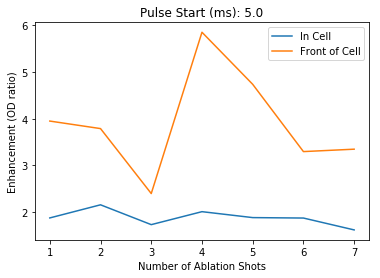

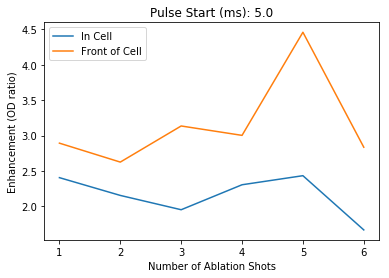

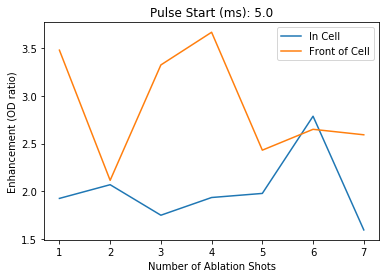

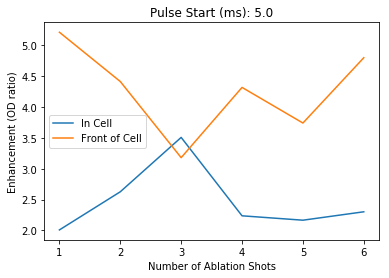

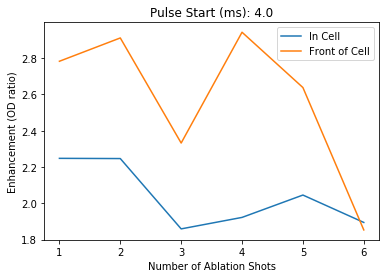

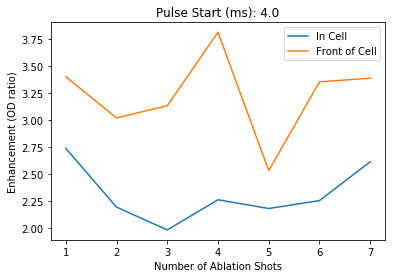

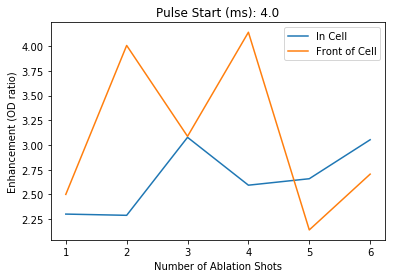

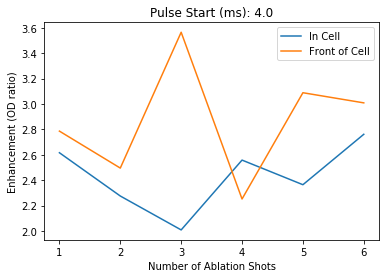

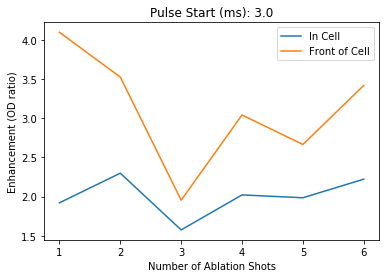

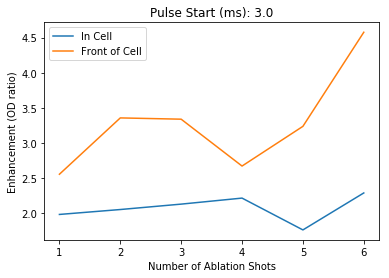

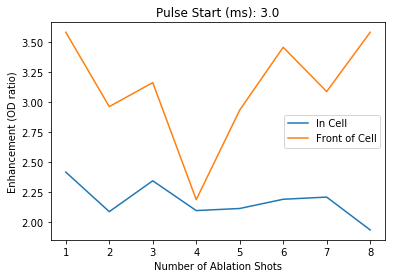

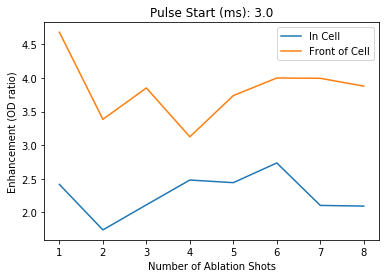

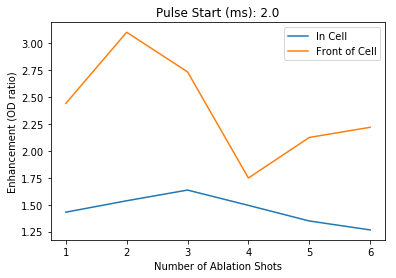

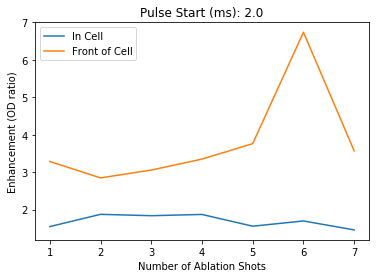

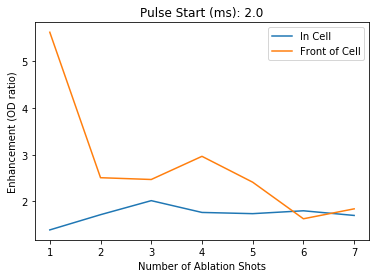

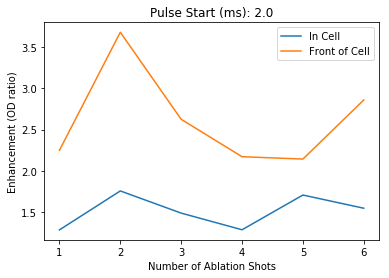

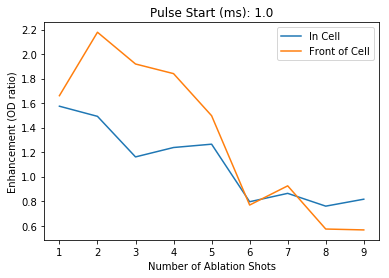

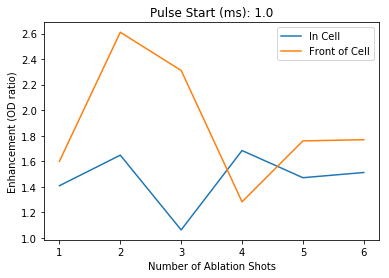

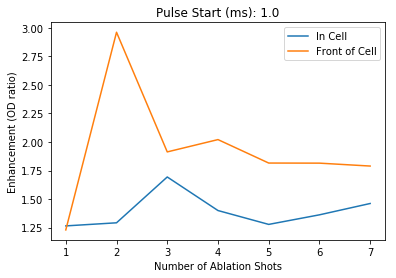

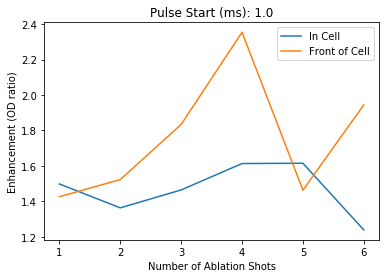

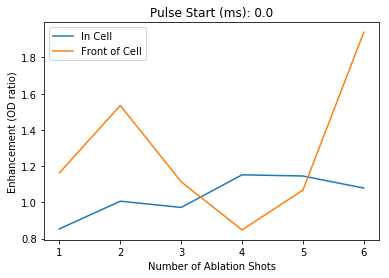

In [17]:
cell = []
err_cell = []
front = []
err_front = []
for _en1,_en2,_iv in zip(en_ch1,en_ch2,iv):
    plt.figure()
    x = np.arange(1,len(_en1)+1)
    plt.title('Pulse Start (ms): {}'.format(_iv))
    plt.ylabel('Enhancement (OD ratio)')
    plt.xlabel('Number of Ablation Shots')
    plt.plot(x,_en1,label='In Cell')
    plt.plot(x,_en2,label='Front of Cell')
    plt.legend(loc='best')
    cell.append(np.array(_en1).mean())
    err_cell.append(np.array(_en1).std())
    front.append(np.array(_en2).mean())
    err_front.append(np.array(_en2).std())

In [18]:
en_cell_sort = np.array(sortData(iv,cell))
err_cell_sort = np.array(sortData(iv,err_cell))
en_front_sort = np.array(sortData(iv,front))
err_front_sort = np.array(sortData(iv,err_front))
iv_sort = np.array(sorted(iv))

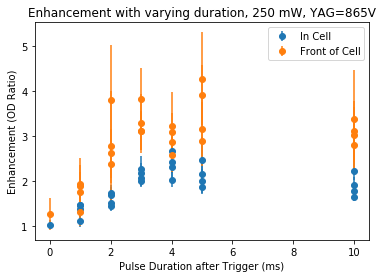

In [19]:
plt.figure()
plt.title('Enhancement with varying duration, 250 mW, YAG=865V')
plt.xlabel('Pulse Duration after Trigger (ms)')
plt.ylabel('Enhancement (OD Ratio)')
plt.errorbar(iv_sort,en_cell_sort,yerr=err_cell_sort,marker='o',linestyle='None',label='In Cell')
plt.errorbar(iv_sort,en_front_sort,yerr=err_front_sort,marker='o',linestyle='None',label='Front of Cell')
plt.legend(loc='best')

In [20]:
lbls = ['Pulse Duration after Trigger (ms)','In Cell Enhancement','In Cell StDev','Front of Cell Enhancement','Front of Cell StDev']
data = np.array([np.array(iv_sort),np.array(en_cell_sort),np.array(err_cell_sort),np.array(en_front_sort),np.array(err_front_sort)])
save_all = []
save_all.append(lbls)
for _data in data.T:
    save_all.append(_data)
writeCSVrows(save_all,'Processed_20190411/Pulsed_Enhancement_vs_Duration_250mW.csv')

Done! Array written to Processed_20190411/Pulsed_Enhancement_vs_Duration_250mW.csv


In [21]:
results=readCSVcolumns('Processed_20190411/data_legend_pulsed_enhancement_fine.csv',skip_header=1)
header = results[1]
print(header)
[iv,starts,stops]= results[0]

Done! Array read from Processed_20190411/data_legend_pulsed_enhancement_fine.csv
[['Start Relative to Trigger (ms)', 'Start', 'Stop']]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

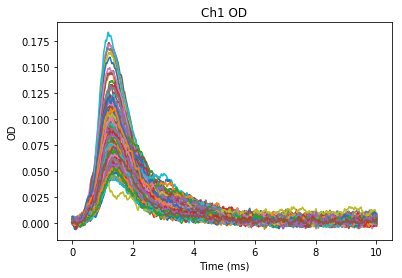

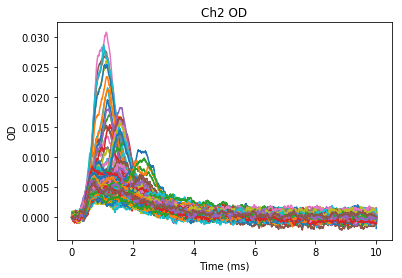

In [22]:
folder = '20190411'
skips = []
ABAB = True

start_arr = starts.astype(int)
stop_arr = stops.astype(int)
iv_arr = iv

enhancement = []

b_ODs = []
ub_ODs = []

progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
display(progress)

for _start,_stop,i in zip(start_arr,stop_arr,range(0,len(start_arr)*3,3)):
    
    ODs_1 = calculateSeriesOD(folder,_start,_stop,skips,ABAB=ABAB)
    p_1 = processData(ODs_1,[0,10])
    progress.value = float(i/(len(start_arr)*3))
    i+=1
    ODs_2 = calculateSeriesOD(folder,_start+1,_stop,skips,ABAB=ABAB)
    p_2 = processData(ODs_2,[0,10])
    progress.value = float(i/(len(start_arr)*3))
    i+=1
    b,ub = identifyBUB(p_1,p_2,equal=True)
    b_ODs.append(b)
    ub_ODs.append(ub)
    progress.value = float(i/(len(start_arr)*3))
    i+=1
progress.value=1
#p=YbOH integrated, Yb integrated, timestamp

In [23]:
en_ch1 = []
en_ch2 = []
for _b,_ub in zip(b_ODs,ub_ODs):
    _en1 = calcEnhancement(_b[0],_ub[0])
    en_ch1.append(_en1)
    _en2 = calcEnhancement(_b[1],_ub[1])
    en_ch2.append(_en2)

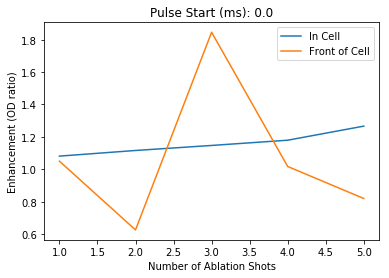

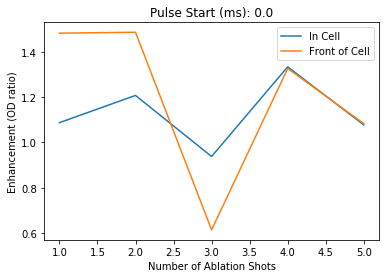

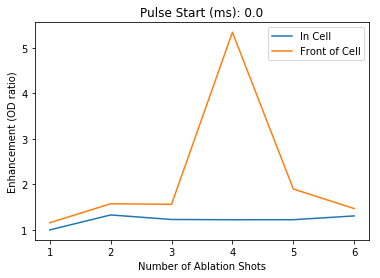

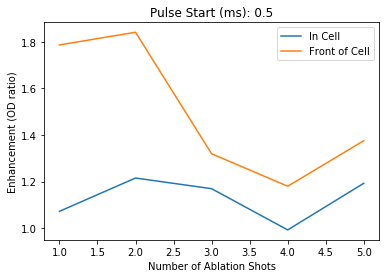

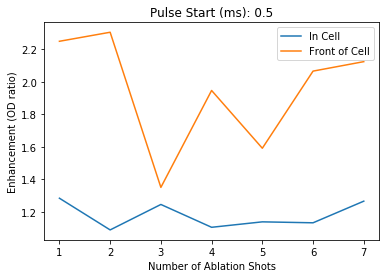

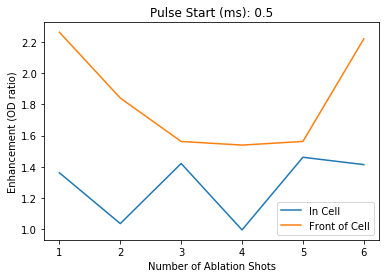

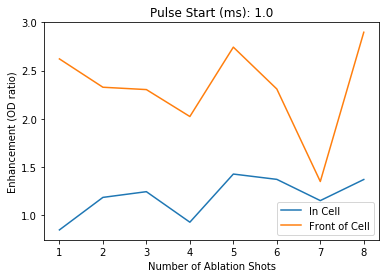

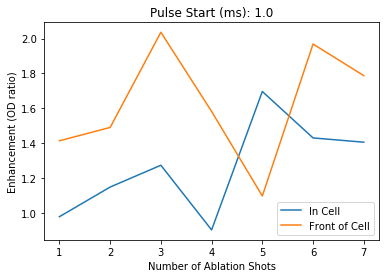

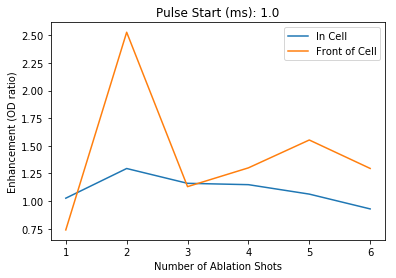

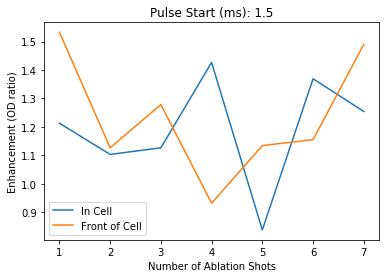

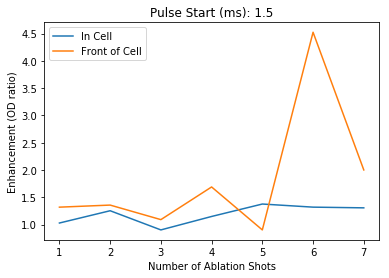

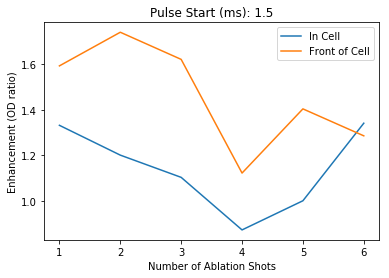

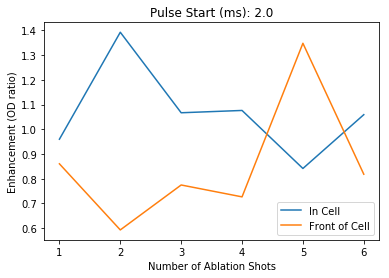

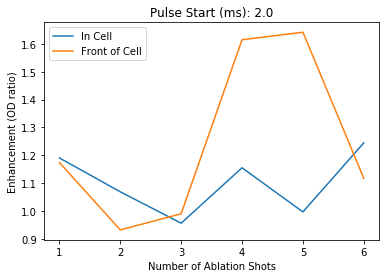

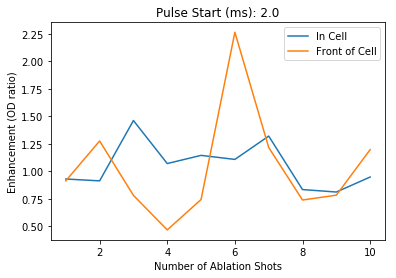

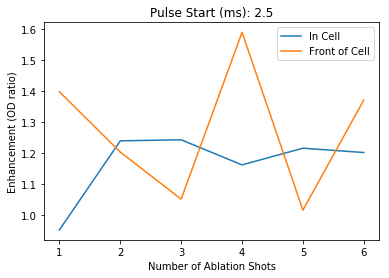

In [24]:
cell = []
err_cell = []
front = []
err_front = []
for _en1,_en2,_iv in zip(en_ch1,en_ch2,iv):
    plt.figure()
    x = np.arange(1,len(_en1)+1)
    plt.title('Pulse Start (ms): {}'.format(_iv))
    plt.ylabel('Enhancement (OD ratio)')
    plt.xlabel('Number of Ablation Shots')
    plt.plot(x,_en1,label='In Cell')
    plt.plot(x,_en2,label='Front of Cell')
    plt.legend(loc='best')
    cell.append(np.array(_en1).mean())
    err_cell.append(np.array(_en1).std())
    front.append(np.array(_en2).mean())
    err_front.append(np.array(_en2).std())

In [25]:
en_cell_sort = np.array(sortData(iv,cell))
err_cell_sort = np.array(sortData(iv,err_cell))
en_front_sort = np.array(sortData(iv,front))
err_front_sort = np.array(sortData(iv,err_front))
iv_sort = np.array(sorted(iv))

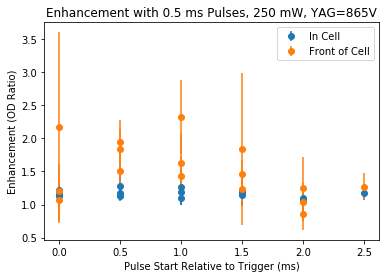

In [26]:
plt.figure()
plt.title('Enhancement with 0.5 ms Pulses, 250 mW, YAG=865V')
plt.xlabel('Pulse Start Relative to Trigger (ms)')
plt.ylabel('Enhancement (OD Ratio)')
plt.errorbar(iv_sort,en_cell_sort,yerr=err_cell_sort,marker='o',linestyle='None',label='In Cell')
plt.errorbar(iv_sort,en_front_sort,yerr=err_front_sort,marker='o',linestyle='None',label='Front of Cell')
plt.legend(loc='best')

In [27]:
lbls = ['Pulse Start Relative to Trigger (ms)','In Cell Enhancement','In Cell StDev','Front of Cell Enhancement','Front of Cell StDev']
data = np.array([np.array(iv_sort),np.array(en_cell_sort),np.array(err_cell_sort),np.array(en_front_sort),np.array(err_front_sort)])
save_all = []
save_all.append(lbls)
for _data in data.T:
    save_all.append(_data)
writeCSVrows(save_all,'Processed_20190411/Pulsed_0p5ms_Enhancement_250mW.csv')

Done! Array written to Processed_20190411/Pulsed_0p5ms_Enhancement_250mW.csv


In [104]:
cell_b = []
cell_ub = []
front_b = []
front_ub = []
for b,ub in zip(b_ODs,ub_ODs):
    cell_b.append(b[0])
    front_b.append(b[1])
    cell_ub.append(ub[0])
    front_ub.append(ub[1])

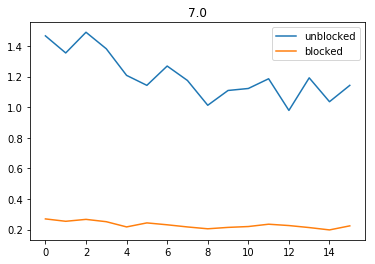

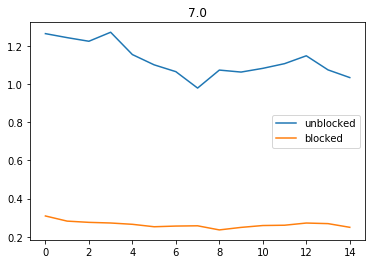

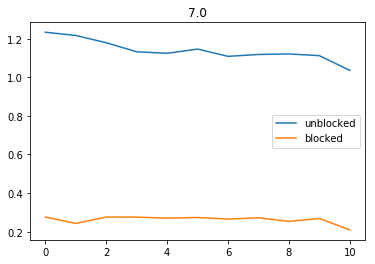

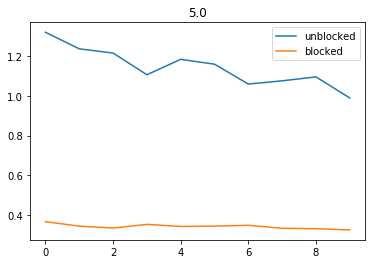

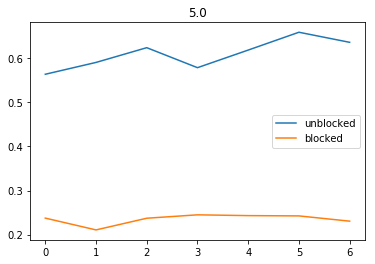

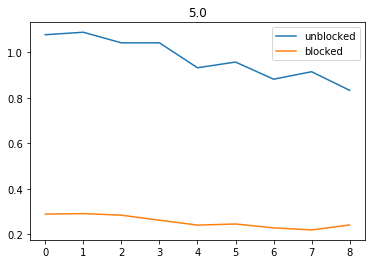

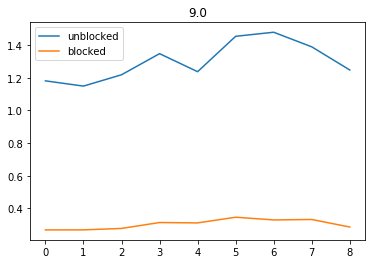

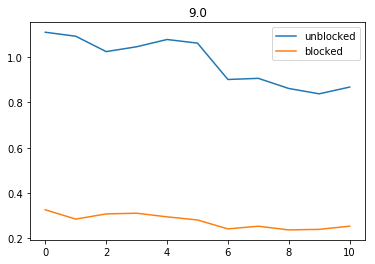

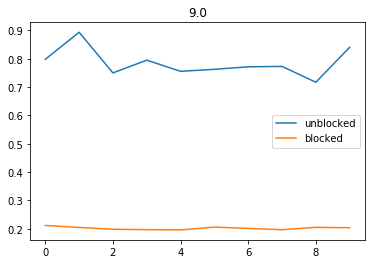

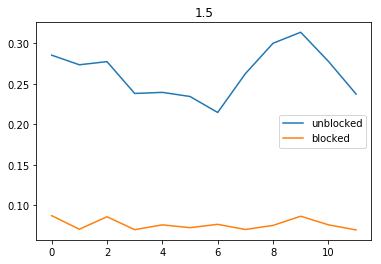

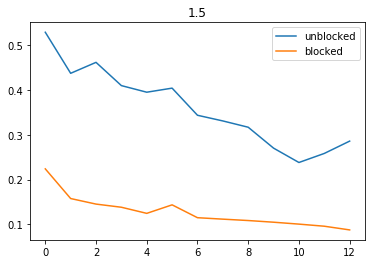

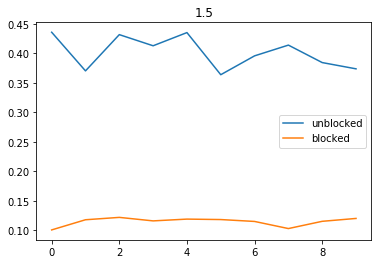

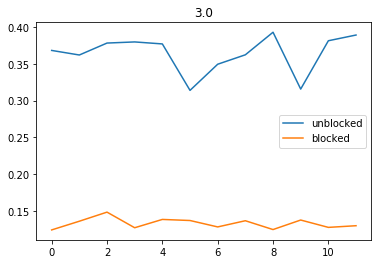

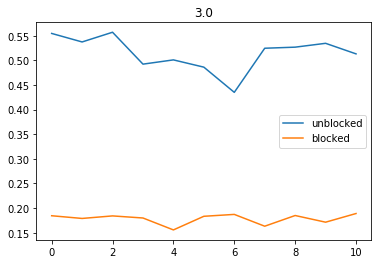

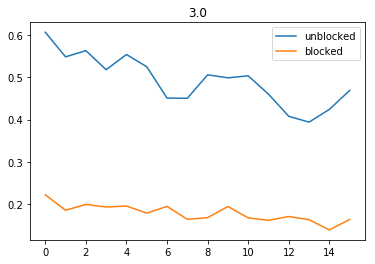

In [105]:
cell_intOD_b = []
cell_intOD_ub = []
cell_std_b = []
cell_std_ub = []
for _b,_ub,_iv in zip(cell_b,cell_ub,iv):
    _b = np.array(_b)
    _ub = np.array(_ub)
    plt.figure()
    plt.title('{}'.format(_iv))
    plt.plot(_ub,label='unblocked')
    plt.plot(_b,label='blocked')
    plt.legend(loc='best')
    cell_intOD_b.append(_b.mean())
    cell_intOD_ub.append(_ub.mean())                  
    cell_std_b.append(_b.std())
    cell_std_ub.append(_ub.std())

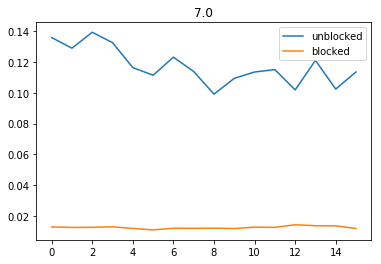

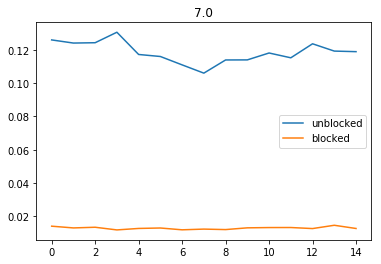

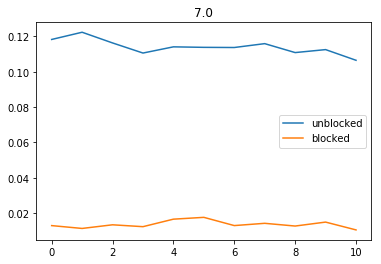

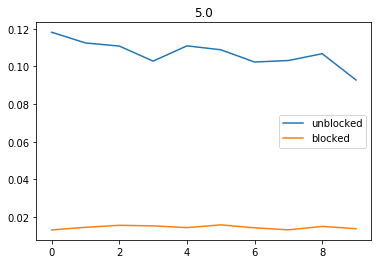

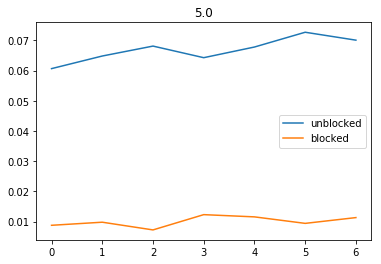

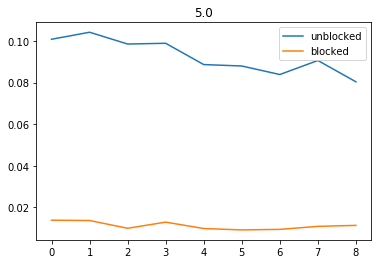

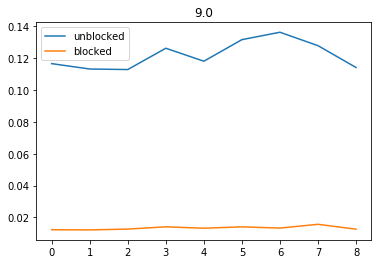

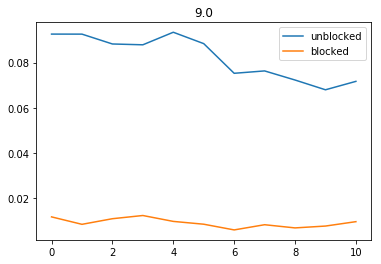

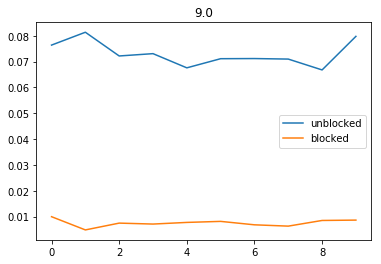

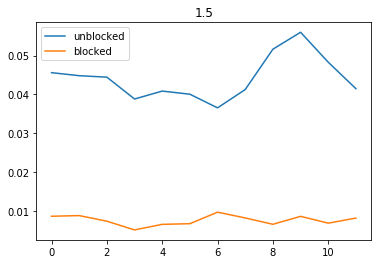

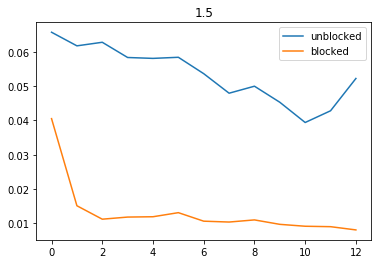

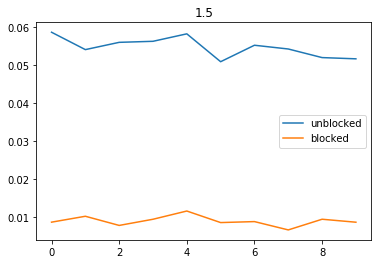

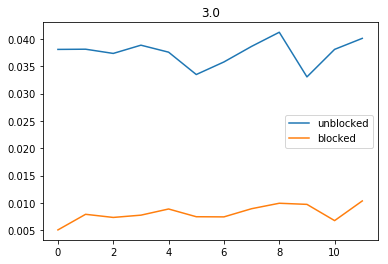

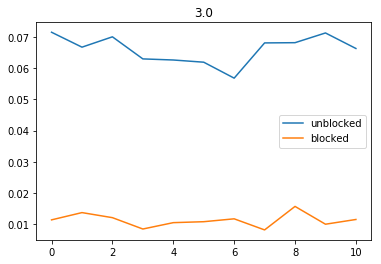

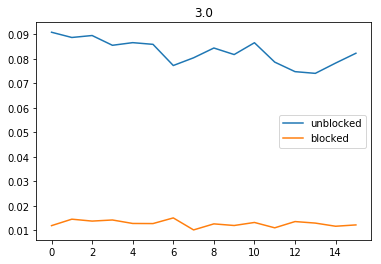

In [106]:
front_intOD_b = []
front_intOD_ub = []
front_std_b = []
front_std_ub = []
for _b,_ub,_iv in zip(front_b,front_ub,iv):
    _b = np.array(_b)
    _ub = np.array(_ub)
    plt.figure()
    plt.title('{}'.format(_iv))
    plt.plot(_ub,label='unblocked')
    plt.plot(_b,label='blocked')
    plt.legend(loc='best')
    front_intOD_b.append(_b.mean())
    front_intOD_ub.append(_ub.mean())                  
    front_std_b.append(_b.std())
    front_std_ub.append(_ub.std())

In [107]:
cell_b_sort = np.array(sortData(iv,cell_intOD_b))
cellstd_b_sort = np.array(sortData(iv,cell_std_b))
cell_ub_sort = np.array(sortData(iv,cell_intOD_ub))
cellstd_ub_sort = np.array(sortData(iv,cell_std_ub))
iv_sort = np.array(sorted(iv))

In [108]:
front_b_sort = np.array(sortData(iv,front_intOD_b))
frontstd_b_sort = np.array(sortData(iv,front_std_b))
front_ub_sort = np.array(sortData(iv,front_intOD_ub))
frontstd_ub_sort = np.array(sortData(iv,front_std_ub))
iv_sort = np.array(sorted(iv))

In [109]:
lbls = ['Gas Flow (SCCM)','Blocked Integrated OD (ms)','Blocked StDev (ms)','Unblocked Integrated OD (ms)','Unblocked StDev (ms)']
data = np.array([np.array(iv_sort),np.array(cell_b_sort),np.array(cellstd_b_sort),np.array(cell_ub_sort),np.array(cellstd_ub_sort)])
save_all = []
save_all.append(lbls)
for _data in data.T:
    save_all.append(_data)
writeCSVrows(save_all,'Processed_20190329/InCell_YbOH_vs_Gas_430mW.csv')

Done! Array written to Processed_20190329/InCell_YbOH_vs_Gas_430mW.csv


In [110]:
lbls = ['Gas Flow (SCCM)','Blocked Integrated OD (ms)','Blocked StDev (ms)','Unblocked Integrated OD (ms)','Unblocked StDev (ms)']
data = np.array([np.array(iv_sort),np.array(front_b_sort),np.array(frontstd_b_sort),np.array(front_ub_sort),np.array(frontstd_ub_sort)])
save_all = []
save_all.append(lbls)
for _data in data.T:
    save_all.append(_data)
writeCSVrows(save_all,'Processed_20190329/FrontofCell_YbOH_vs_Gas_430mW.csv')

Done! Array written to Processed_20190329/FrontofCell_YbOH_vs_Gas_430mW.csv


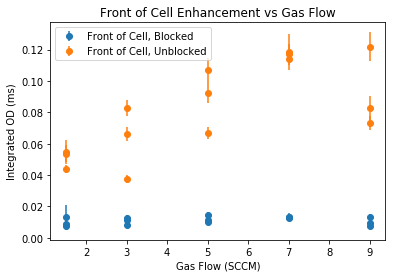

In [111]:
plt.figure()
plt.title('Front of Cell Enhancement vs Gas Flow')
plt.xlabel('Gas Flow (SCCM)')
plt.ylabel('Integrated OD (ms)')
plt.errorbar(iv_sort,front_b_sort,yerr=frontstd_b_sort,marker='o',linestyle='None',label='Front of Cell, Blocked')
plt.errorbar(iv_sort,front_ub_sort,yerr=frontstd_ub_sort,marker='o',linestyle='None',label='Front of Cell, Unblocked')
plt.legend(loc='best')

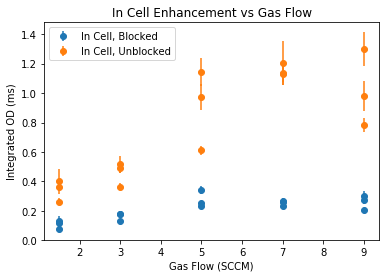

In [112]:
plt.figure()
plt.title('In Cell Enhancement vs Gas Flow')
plt.xlabel('Gas Flow (SCCM)')
plt.ylabel('Integrated OD (ms)')
plt.errorbar(iv_sort,cell_b_sort,yerr=cellstd_b_sort,marker='o',linestyle='None',label='In Cell, Blocked')
plt.errorbar(iv_sort,cell_ub_sort,yerr=cellstd_ub_sort,marker='o',linestyle='None',label='In Cell, Unblocked')
plt.legend(loc='best')

In [113]:
ex_ub = []
exerr_ub = []
ex_b = []
exerr_b = []
for _cell_b,_cellstd_b,_cell_ub,_cellstd_ub,_front_b,_frontstd_b,_front_ub,_frontstd_ub,_iv in zip(cell_b_sort,cellstd_b_sort,cell_ub_sort,cellstd_ub_sort,front_b_sort,frontstd_b_sort,front_ub_sort,frontstd_ub_sort,iv_sort):
    _ex_ub = _front_ub/_cell_ub
    _ex_b = _front_b/_cell_b
    _exerr_ub = _ex_ub*np.sqrt((_cellstd_ub/_cell_ub)**2+(_frontstd_ub/_front_ub)**2)
    _exerr_b = _ex_b*np.sqrt((_cellstd_b/_cell_b)**2+(_frontstd_b/_front_b)**2)
    ex_ub.append(_ex_ub)
    ex_b.append(_ex_b)
    exerr_ub.append(_exerr_ub)
    exerr_b.append(_exerr_b)

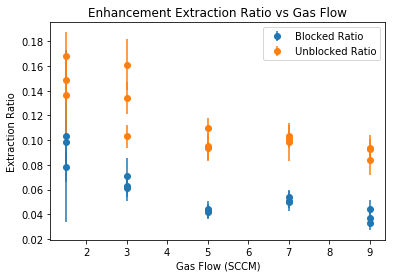

In [114]:
plt.figure()
plt.title('Enhancement Extraction Ratio vs Gas Flow')
plt.xlabel('Gas Flow (SCCM)')
plt.ylabel('Extraction Ratio')
plt.errorbar(iv_sort,ex_b,yerr=exerr_b,marker='o',linestyle='None',label='Blocked Ratio')
plt.errorbar(iv_sort,ex_ub,yerr=exerr_ub,marker='o',linestyle='None',label='Unblocked Ratio')
plt.legend(loc='best')

Read data from saved file

In [17]:
results=readCSVcolumns('Processed_20190329/FrontofCell_YbOH_vs_Gas_84mW.csv',skip_header=1)
header = results[1]
print(header)
[gas,front_b,front_std_b,front_ub,front_std_ub] = results[0]

Done! Array read from Processed_20190329/FrontofCell_YbOH_vs_Gas_84mW.csv
[['Gas Flow (SCCM)', 'Blocked Integrated OD (ms)', 'Blocked StDev (ms)', 'Unblocked Integrated OD (ms)', 'Unblocked StDev (ms)']]


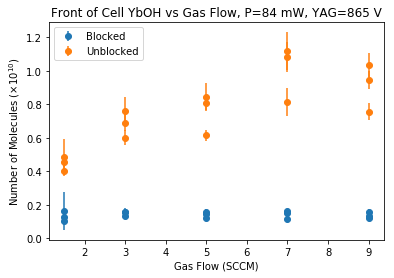

In [18]:
factor = 1.158*10 #1.158 * 10^11 /ms
plt.figure()
plt.title('Front of Cell YbOH vs Gas Flow, P=84 mW, YAG=865 V')
plt.xlabel('Gas Flow (SCCM)')
plt.ylabel(r'Number of Molecules ($\times 10^{10}$)')
plt.errorbar(gas,factor*front_b,yerr=factor*front_std_b,marker='o',linestyle='None',label='Blocked')
plt.errorbar(gas,factor*front_ub,yerr=factor*front_std_ub,marker='o',linestyle='None',label='Unblocked')
plt.legend(loc='best')